In [1]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [3]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

In [4]:
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

In [5]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

In [6]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

In [7]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

In [8]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

In [9]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2') for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [10]:
def get_kaze(images, name='kaze', save=False):
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [11]:
def get_sift(images, name='sift', save=False):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [12]:
def return_sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

In [13]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [14]:
def return_surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

In [15]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [16]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

In [17]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [18]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [19]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['NB', 'SVM', 'XGB', 'MLP', 'ADA', 'BAG', 'RF']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

In [20]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [21]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

In [22]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

In [23]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,20))
    for i, img in enumerate(mat, start=1):
        plt.subplot(4, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

In [24]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

In [25]:
full_data_x, full_data_y = read_images('cell_images')

In [26]:
full_data_x.shape, full_data_y.shape

((27558, 32, 32, 3), (27558,))

In [27]:
full_data_x[2].shape

(32, 32, 3)

In [28]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)


In [29]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape


((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [30]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)


In [31]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape


((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [32]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

np.save('data/data_x.npy', data_x)
np.save('data/data_y.npy', data_y)
np.save('data/test_x.npy', test_x)
np.save('data/test_y.npy', test_y)

In [33]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

data_x = np.load('data/data_x.npy')
data_y = np.load('data/data_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')

In [34]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [35]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [36]:
infected_img = train_imgs[train_y == 0][8]
uninfected_img = train_imgs[train_y == 1][4]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [42]:
vis_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
sift = np.zeros((2, 32, 32, 3), dtype='uint8')
#surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, vis_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_sift_kp(classes[i]))
    #surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_surf_kp(classes[i]))

In [43]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(vis_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
#for i in range(len(classes)):
 #   data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
#for i in range(len(classes)):
#    img_name_arr.append('SURF')

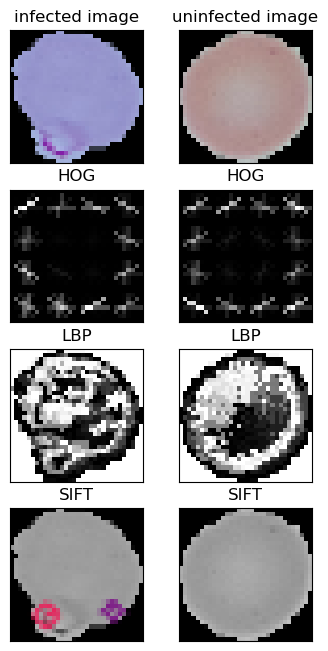

In [45]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()

In [47]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [48]:
hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

In [49]:
hog_train.shape, hog_val.shape

((17636, 324), (4410, 324))

In [50]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [51]:
lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

In [52]:
lbp_train.shape, lbp_val.shape

((17636, 1024), (4410, 1024))

In [53]:
kaze_train = get_kaze(train_imgs, name='kaze_train', save=True)
kaze_val = get_kaze(val_imgs, name='kaze_val', save=True)

Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [54]:
kaze_train = load_feature('cache/kaze_train.pkl')
kaze_val = load_feature('cache/kaze_val.pkl')

In [55]:
kaze_train.shape, kaze_val.shape

((17636, 2048), (4410, 2048))

In [56]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [57]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [58]:
sift_train.shape, sift_val.shape

((17636, 1920), (4410, 1920))

In [59]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [60]:
flat_rgb_train = load_feature('cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('cache/flat_rgb_val.pkl')

In [61]:
flat_rgb_train.shape, flat_rgb_val.shape

((17636, 3072), (4410, 3072))

In [62]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [63]:
flat_gray_train = load_feature('cache/flat_gray_train.pkl')
flat_gray_val = load_feature('cache/flat_gray_val.pkl')

In [64]:
flat_gray_train.shape, flat_gray_val.shape

((17636, 1024), (4410, 1024))

In [65]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [66]:
hist_train = load_feature('cache/hist_train.pkl')
hist_val = load_feature('cache/hist_val.pkl')

In [67]:
hist_train.shape, hist_val.shape

((17636, 512), (4410, 512))

In [68]:
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [69]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [70]:
np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

In [71]:
pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

In [72]:
pca_hog_train.shape, pca_hog_val.shape

((17636, 10), (4410, 10))

In [73]:
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [74]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [75]:
np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

In [76]:
pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

In [77]:
pca_lbp_train.shape, pca_lbp_val.shape

((17636, 10), (4410, 10))

In [78]:
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

In [79]:
pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

In [80]:
np.save('cache/pca_kaze_train.npy', pca_kaze_train)
np.save('cache/pca_kaze_val.npy', pca_kaze_val)

In [81]:
pca_kaze_train = np.load('cache/pca_kaze_train.npy')
pca_kaze_val = np.load('cache/pca_kaze_val.npy')

In [82]:
pca_kaze_train.shape, pca_kaze_val.shape

((17636, 10), (4410, 10))

In [83]:
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

In [84]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

In [85]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

In [86]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

In [87]:
pca_sift_train.shape, pca_sift_val.shape

((17636, 5), (4410, 5))

In [88]:
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

In [89]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [90]:
np.save('cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [91]:
pca_flat_rgb_train = np.load('cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('cache/pca_flat_rgb_val.npy')

In [92]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((17636, 10), (4410, 10))

In [93]:
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

In [94]:
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [95]:
np.save('cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('cache/pca_flat_gray_val.npy', pca_flat_gray_val)

In [96]:
pca_flat_gray_train = np.load('cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('cache/pca_flat_gray_val.npy')

In [97]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((17636, 6), (4410, 6))

In [98]:
# norm_hist_train, norm_hist_val = norm_features_minmax(hist_train, hist_val)
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [99]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [100]:
np.save('cache/pca_hist_train.npy', pca_hist_train)
np.save('cache/pca_hist_val.npy', pca_hist_val)

In [101]:
pca_hist_train = np.load('cache/pca_hist_train.npy')
pca_hist_val = np.load('cache/pca_hist_val.npy')

In [102]:
pca_hist_train.shape, pca_hist_val.shape

((17636, 10), (4410, 10))

In [103]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
pca_array.append(pca_sift_train)
#pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)
len(pca_array)

7

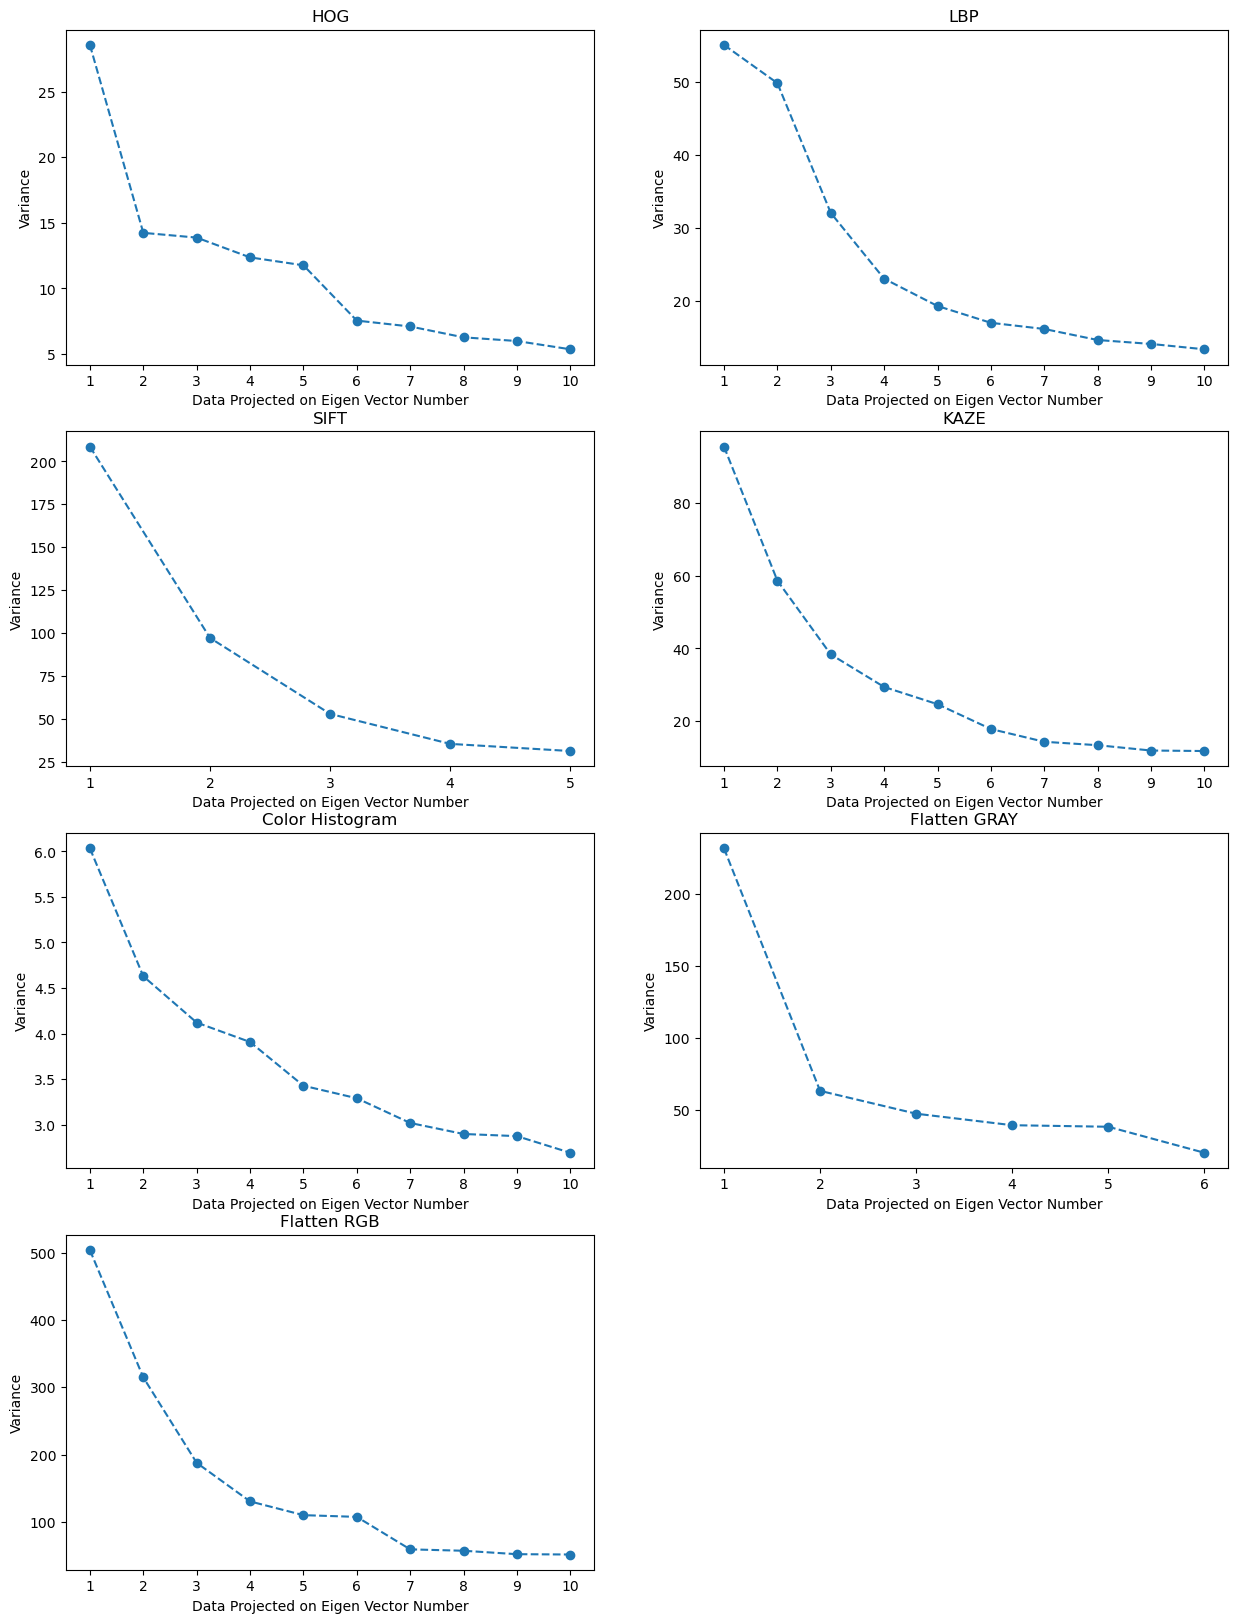

In [105]:
pca_projection(pca_array, ['HOG', 'LBP', 'SIFT', 'KAZE', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

In [106]:
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)

In [107]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [108]:
np.save('cache/lda_hog_train.npy', lda_hog_train)
np.save('cache/lda_hog_val.npy', lda_hog_val)

In [109]:
lda_hog_train = np.load('cache/lda_hog_train.npy')
lda_hog_val = np.load('cache/lda_hog_val.npy')

In [110]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [111]:
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)

In [112]:
np.save('cache/lda_lbp_train.npy', lda_lbp_train)
np.save('cache/lda_lbp_val.npy', lda_lbp_val)

In [113]:
lda_lbp_train = np.load('cache/lda_lbp_train.npy')
lda_lbp_val = np.load('cache/lda_lbp_val.npy')

In [114]:
lda_lbp_train.shape, lda_lbp_val.shape

((17636, 1), (4410, 1))

In [115]:
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)

In [116]:
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)

In [117]:
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

In [118]:
lda_sift_train.shape, lda_sift_val.shape

((17636, 1), (4410, 1))

In [119]:
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)

In [120]:
np.save('cache/lda_hist_train.npy', lda_hist_train)
np.save('cache/lda_hist_val.npy', lda_hist_val)

In [121]:
lda_hist_train = np.load('cache/lda_hist_train.npy')
lda_hist_val = np.load('cache/lda_hist_val.npy')

In [122]:
lda_hist_train.shape, lda_hist_val.shape

((17636, 1), (4410, 1))

In [124]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train,  flat_rgb_train, lbp_train, kaze_train, sift_train], 
                  [hog_val, hist_val,  flat_rgb_val, lbp_val, kaze_val, sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [125]:
features_train.shape, features_val.shape

((17636, 8900), (4410, 8900))

In [126]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train, pca_sift_train, pca_flat_rgb_train, pca_hist_train], 
                  [pca_hog_val, pca_lbp_val, pca_sift_val, pca_flat_rgb_val, pca_hist_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [127]:
features_train.shape, features_val.shape

((17636, 45), (4410, 45))

In [128]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train, lda_sift_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val, lda_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [129]:
features_train_lda.shape, features_val_lda.shape

((17636, 4), (4410, 4))

In [130]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

In [131]:
np.save('cache/lda_on_pca_train.npy', lda_on_pca_train)
np.save('cache/lda_on_pca_val.npy', lda_on_pca_val)

In [132]:
lda_on_pca_train = np.load('cache/lda_on_pca_train.npy')
lda_on_pca_val = np.load('cache/lda_on_pca_val.npy')

In [133]:
lda_on_pca_train.shape, lda_on_pca_val.shape

((17636, 1), (4410, 1))

In [134]:
features_t = pca_hist_train
features_v = pca_hist_val

In [135]:
features_t.shape, features_v.shape

((17636, 10), (4410, 10))

In [136]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.8848072562358277
[[1922  265]
 [ 243 1980]]
Recall in 'RF' = 0.8788294467306813
Precision in 'RF' = 0.8877598152424943
F1 Score in 'RF' = 0.8832720588235294


In [137]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [138]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.8879818594104308
[[1942  245]
 [ 249 1974]]
Recall in 'BAG' = 0.8879743941472337
Precision in 'BAG' = 0.8863532633500685
F1 Score in 'BAG' = 0.8871630881681133


In [139]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [140]:
model3 = train_model(features_train, train_y, model_name='ADA', validation=(features_val, val_y))

Validation Accuracy in 'ADA' = 0.8868480725623583
[[1925  262]
 [ 237 1986]]
Recall in 'ADA' = 0.8802011888431641
Precision in 'ADA' = 0.8903792784458835
F1 Score in 'ADA' = 0.8852609795355253


In [141]:
prob3 = model3.predict_proba(features_val)
prob30 = prob3[:,0].reshape(prob3.shape[0], 1)
prob31 = prob3[:,1].reshape(prob3.shape[0], 1)

In [142]:

model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6800453514739229
[[ 962 1225]
 [ 186 2037]]
Recall in 'NB' = 0.4398719707361683
Precision in 'NB' = 0.837979094076655
F1 Score in 'NB' = 0.576911544227886


In [143]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [144]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.8746031746031746
[[1894  293]
 [ 260 1963]]
Recall in 'SVM' = 0.866026520347508
Precision in 'SVM' = 0.8792943361188487
F1 Score in 'SVM' = 0.8726099976963834


In [145]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [146]:
model6 = train_model(np.array(features_train), train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.9210884353741496
[[1997  190]
 [ 158 2065]]
Recall in 'XGB' = 0.9131229995427527
Precision in 'XGB' = 0.9266821345707656
F1 Score in 'XGB' = 0.9198526024873331


In [147]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [148]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.772562358276644
[[1557  630]
 [ 373 1850]]
Recall in 'KNN' = 0.7119341563786008
Precision in 'KNN' = 0.8067357512953368
F1 Score in 'KNN' = 0.7563760019431625


In [149]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

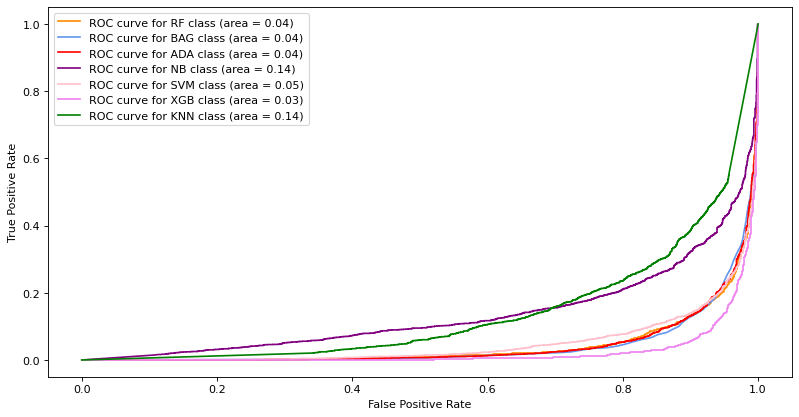

In [150]:
prob = np.concatenate((prob10, prob20, prob30, prob40, prob50, prob60, prob70), axis=1)
plot_combine_roc(val_y, prob)

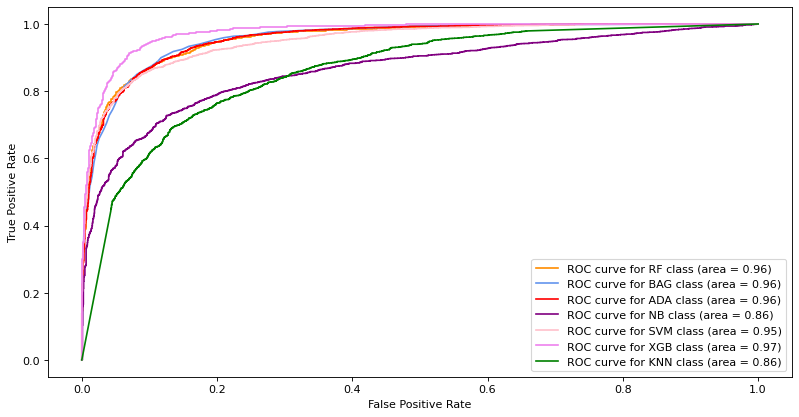

In [151]:
prob = np.concatenate((prob11, prob21, prob31, prob41, prob51, prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

In [152]:
model8 = train_model(features_train_lda, train_y, model_name='RF', validation=(features_val_lda, val_y))

Validation Accuracy in 'RF' = 0.8609977324263038
[[1872  315]
 [ 298 1925]]
Recall in 'RF' = 0.8559670781893004
Precision in 'RF' = 0.8626728110599078
F1 Score in 'RF' = 0.8593068625200826


In [153]:
prob8 = model8.predict_proba(features_val_lda)
prob80 = prob8[:,0].reshape(prob8.shape[0], 1)
prob81 = prob8[:,1].reshape(prob8.shape[0], 1)

In [154]:
model9 = train_model(features_train_lda, train_y, model_name='BAG', validation=(features_val_lda, val_y))

Validation Accuracy in 'BAG' = 0.853514739229025
[[1845  342]
 [ 304 1919]]
Recall in 'BAG' = 0.8436213991769548
Precision in 'BAG' = 0.8585388552815263
F1 Score in 'BAG' = 0.8510147601476016


In [155]:
prob9 = model9.predict_proba(features_val_lda)
prob90 = prob9[:,0].reshape(prob9.shape[0], 1)
prob91 = prob9[:,1].reshape(prob9.shape[0], 1)

In [156]:
model10 = train_model(features_train_lda, train_y, model_name='ADA', validation=(features_val_lda, val_y))


Validation Accuracy in 'ADA' = 0.8551020408163266
[[1834  353]
 [ 286 1937]]
Recall in 'ADA' = 0.838591678097851
Precision in 'ADA' = 0.8650943396226415
F1 Score in 'ADA' = 0.851636870211284


In [157]:
prob10 = model10.predict_proba(features_val_lda)
prob100 = prob10[:,0].reshape(prob10.shape[0], 1)
prob101 = prob10[:,1].reshape(prob10.shape[0], 1)

In [158]:
model11 = train_model(features_train_lda, train_y, model_name='NB', validation=(features_val_lda, val_y))


Validation Accuracy in 'NB' = 0.8496598639455782
[[1799  388]
 [ 275 1948]]
Recall in 'NB' = 0.8225880201188843
Precision in 'NB' = 0.8674059787849566
F1 Score in 'NB' = 0.844402722365642


In [159]:
prob11 = model11.predict_proba(features_val_lda)
prob110 = prob11[:,0].reshape(prob11.shape[0], 1)
prob111 = prob11[:,1].reshape(prob11.shape[0], 1)

In [160]:
model12 = train_model(features_train_lda, train_y, model_name='SVM', validation=(features_val_lda, val_y))


Validation Accuracy in 'SVM' = 0.8675736961451247
[[1908  279]
 [ 305 1918]]
Recall in 'SVM' = 0.8724279835390947
Precision in 'SVM' = 0.8621780388612743
F1 Score in 'SVM' = 0.8672727272727272


In [161]:
prob12 = model12.predict_proba(features_val_lda)
prob120 = prob12[:,0].reshape(prob12.shape[0], 1)
prob121 = prob12[:,1].reshape(prob12.shape[0], 1)

In [162]:
model13 = train_model(features_train_lda, train_y, model_name='XGB', validation=(features_val_lda, val_y))


Validation Accuracy in 'XGB' = 0.8492063492063492
[[1821  366]
 [ 299 1924]]
Recall in 'XGB' = 0.8326474622770919
Precision in 'XGB' = 0.8589622641509433
F1 Score in 'XGB' = 0.8456001857441374


In [163]:
prob13 = model13.predict_proba(features_val_lda)
prob130 = prob13[:,0].reshape(prob13.shape[0], 1)
prob131 = prob13[:,1].reshape(prob13.shape[0], 1)

In [164]:
model14 = train_model(features_train_lda, train_y, model_name='KNN', validation=(features_val_lda, val_y))


Validation Accuracy in 'KNN' = 0.8458049886621315
[[1842  345]
 [ 335 1888]]
Recall in 'KNN' = 0.8422496570644719
Precision in 'KNN' = 0.846118511713367
F1 Score in 'KNN' = 0.844179651695692


In [165]:
prob14 = model14.predict_proba(features_val_lda)
prob140 = prob14[:,0].reshape(prob14.shape[0], 1)
prob141 = prob14[:,1].reshape(prob14.shape[0], 1)

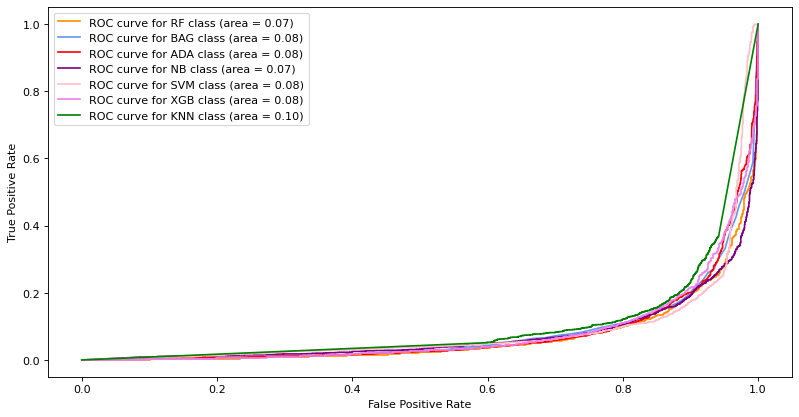

In [166]:
prob = np.concatenate((prob80, prob90, prob100, prob110, prob120, prob130, prob140), axis=1)
plot_combine_roc(val_y, prob)

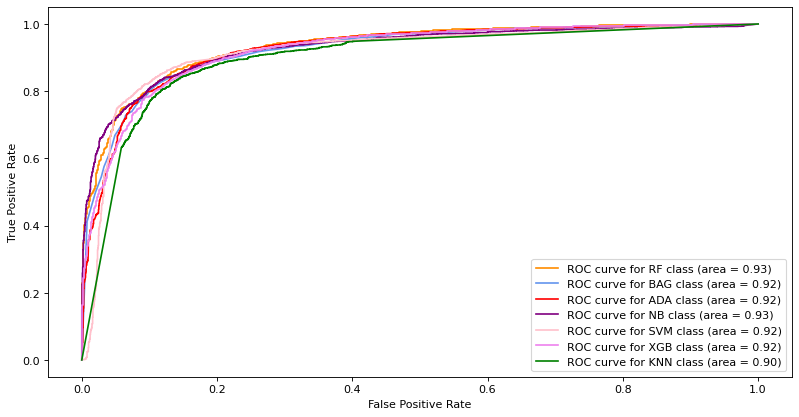

In [167]:
prob = np.concatenate((prob81, prob91, prob101, prob111, prob121, prob131, prob141), axis=1)
plot_combine_roc(val_y, prob)

In [168]:
model15 = train_model(lda_on_pca_train, train_y, model_name='RF', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'RF' = 0.8356009070294784
[[1861  326]
 [ 399 1824]]
Recall in 'RF' = 0.8509373571101966
Precision in 'RF' = 0.8234513274336284
F1 Score in 'RF' = 0.8369687429727906


In [169]:
prob15 = model15.predict_proba(lda_on_pca_val)
prob150 = prob15[:,0].reshape(prob15.shape[0], 1)
prob151 = prob15[:,1].reshape(prob15.shape[0], 1)

In [170]:
model16 = train_model(lda_on_pca_train, train_y, model_name='BAG', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'BAG' = 0.7718820861678004
[[1687  500]
 [ 506 1717]]
Recall in 'BAG' = 0.7713763145861912
Precision in 'BAG' = 0.769265845873233
F1 Score in 'BAG' = 0.7703196347031964


In [171]:
prob16 = model16.predict_proba(lda_on_pca_val)
prob160 = prob16[:,0].reshape(prob16.shape[0], 1)
prob161 = prob16[:,1].reshape(prob16.shape[0], 1)

In [172]:
model17 = train_model(lda_on_pca_train, train_y, model_name='ADA', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'ADA' = 0.8408163265306122
[[1884  303]
 [ 399 1824]]
Recall in 'ADA' = 0.8614540466392319
Precision in 'ADA' = 0.8252299605781866
F1 Score in 'ADA' = 0.8429530201342282


In [173]:
prob17 = model17.predict_proba(lda_on_pca_val)
prob170 = prob17[:,0].reshape(prob17.shape[0], 1)
prob171 = prob17[:,1].reshape(prob17.shape[0], 1)

In [174]:
model18 = train_model(lda_on_pca_train, train_y, model_name='NB', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'NB' = 0.826530612244898
[[1688  499]
 [ 266 1957]]
Recall in 'NB' = 0.7718335619570188
Precision in 'NB' = 0.8638689866939611
F1 Score in 'NB' = 0.8152620140062786


In [175]:
prob18 = model18.predict_proba(lda_on_pca_val)
prob180 = prob18[:,0].reshape(prob18.shape[0], 1)
prob181 = prob18[:,1].reshape(prob18.shape[0], 1)

In [176]:
model19 = train_model(lda_on_pca_train, train_y, model_name='SVM', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'SVM' = 0.8424036281179138
[[1882  305]
 [ 390 1833]]
Recall in 'SVM' = 0.8605395518975766
Precision in 'SVM' = 0.8283450704225352
F1 Score in 'SVM' = 0.8441354563803544


In [177]:
prob19 = model19.predict_proba(lda_on_pca_val)
prob190 = prob19[:,0].reshape(prob19.shape[0], 1)
prob191 = prob19[:,1].reshape(prob19.shape[0], 1)

In [178]:
model20 = train_model(lda_on_pca_train, train_y, model_name='XGB', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'XGB' = 0.8369614512471655
[[1876  311]
 [ 408 1815]]
Recall in 'XGB' = 0.8577960676726109
Precision in 'XGB' = 0.8213660245183888
F1 Score in 'XGB' = 0.8391858644598524


In [179]:
prob20 = model20.predict_proba(lda_on_pca_val)
prob200 = prob20[:,0].reshape(prob20.shape[0], 1)
prob201 = prob20[:,1].reshape(prob20.shape[0], 1)

In [180]:
model21 = train_model(lda_on_pca_train, train_y, model_name='KNN', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'KNN' = 0.7941043083900227
[[1739  448]
 [ 460 1763]]
Recall in 'KNN' = 0.7951531778692272
Precision in 'KNN' = 0.7908140063665302
F1 Score in 'KNN' = 0.7929776561787506


In [181]:
prob21 = model21.predict_proba(lda_on_pca_val)
prob210 = prob21[:,0].reshape(prob21.shape[0], 1)
prob211 = prob21[:,1].reshape(prob21.shape[0], 1)

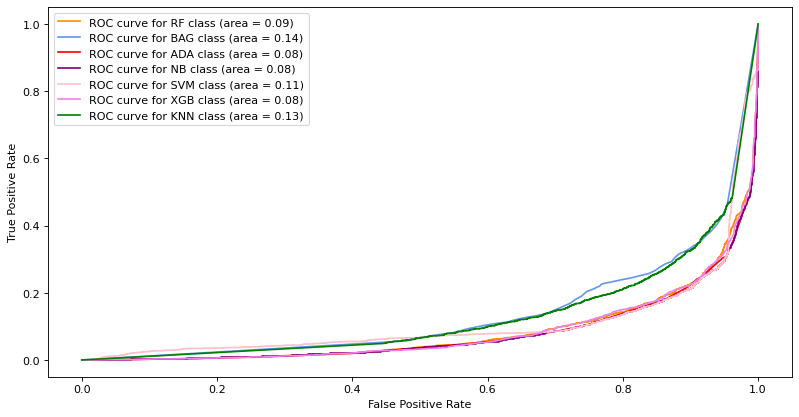

In [182]:
prob = np.concatenate((prob150, prob160, prob170, prob180, prob190, prob200, prob210), axis=1)
plot_combine_roc(val_y, prob)

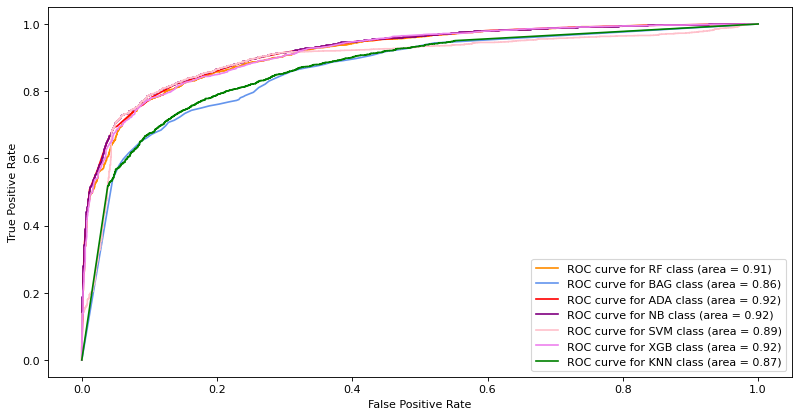

In [183]:
prob = np.concatenate((prob151, prob161, prob171, prob181, prob191, prob201, prob211), axis=1)
plot_combine_roc(val_y, prob)

In [184]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
lbp_comp_train = combine_features([lbp_train, lbp_val], horizontal=False)
kaze_comp_train = combine_features([kaze_train, kaze_val], horizontal=False)
sift_comp_train = combine_features([sift_train, sift_val], horizontal=False)
#surf_comp_train = combine_features([surf_train, surf_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [185]:
data_y = np.hstack([train_y, val_y])


In [186]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=30)
pca_lbp_comp_train = pca.fit_transform(lbp_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_kaze_comp_train = pca.fit_transform(kaze_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=15)
pca_sift_comp_train = pca.fit_transform(sift_comp_train)
pcas_array.append(pca)

#pca = PCA(n_components=5)
#pca_surf_comp_train = pca.fit_transform(surf_comp_train)
#pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

In [187]:
reduced_train_features=[pca_hog_comp_train,
                        pca_lbp_comp_train,
                        pca_kaze_comp_train,
                        pca_sift_comp_train,
                        #pca_surf_comp_train,
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [188]:
hog_test = get_hog(test_x, name='hog_test', save=True)
lbp_test = get_lbp(test_x, name='lbp_test', save=True)
kaze_test = get_kaze(test_x, name='kaze_test', save=True)
sift_test = get_sift(test_x, name='sift_test', save=True)
#surf_test = get_surf(test_x, name='surf_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/lbp_test.pkl
Feature saved with name cache/kaze_test.pkl
Feature saved with name cache/sift_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [189]:
test_features= [hog_test,
                lbp_test,
                kaze_test,
                sift_test,
                #surf_test,
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [190]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 6:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [191]:
features_comp_train.shape, features_test.shape

((22046, 115), (5512, 115))

In [192]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [193]:
y_hat = comp_model.predict(features_test)

In [194]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.8109579100145138
[[2232  547]
 [ 495 2238]]
0.8184818481848185 0.8031666066930551 0.810751907010534


In [228]:
clf = RandomForestClassifier(n_estimators=200)

param_dist = {"max_depth": [3, None],
              "class_weight" : ["balanced", "balanced_subsample", None],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5, return_train_score=True)

In [229]:
random_search.fit(features_train_lda, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=200),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000024D03925490>},
                   return_train_score=True)

In [230]:
print(random_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_class_weight', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [231]:
a1 = random_search.cv_results_['param_bootstrap']
a2 = random_search.cv_results_['param_class_weight']
a3 = random_search.cv_results_['param_criterion']
a4 = random_search.cv_results_['param_max_depth']
a5 = random_search.cv_results_['param_min_samples_split']

a6 = random_search.cv_results_['mean_train_score']
a7 = random_search.cv_results_['mean_test_score']

In [232]:
print(random_search.best_params_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 7}


In [233]:
arr = []
for key in random_search.best_params_.keys():
    arr.append(key)
    
arr.append('mean_train_score')
arr.append('mean_test_score')
print(arr)

['bootstrap', 'class_weight', 'criterion', 'max_depth', 'min_samples_split', 'mean_train_score', 'mean_test_score']


In [238]:
np.savez('output/random_forest.npz', a1=a1, a2=a2, a3=a3, a4=a4, a5=a5, a6=a6, a7=a7, arr=arr)

In [240]:
y1 = random_search.predict(features_val_lda)
metrics.accuracy_score(y1, val_y)

0.8578231292517007

In [241]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)
y_hat3 = model3.predict(features_val)
y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

In [243]:
class MetricTools:
    @staticmethod
    def accuracy(y, y_hat):
        """
        y [np array]: actual labels
        y_hat [np array]: predicted labels
        
        return: accuracy between 0 and 1
        """
        return np.sum(y == y_hat) / len(y)
    
    @staticmethod
    def prec_recall(y, y_hat, nclasses):
        """
        y [np array]: actual labels
        y_hat [np array]: predicted labels
        nclasses [integer]: number of classes in the dataset.
        
        return: precision, recall
        """
        cm = MetricTools.confusion_matrix(y, y_hat, nclasses)
        
        rec = cm[0,0] / np.sum(cm[0,:])
        prec = cm[0,0] / np.sum(cm[:,0])
        
        return prec, rec
    
    @staticmethod
    def confusion_matrix(y, y_hat, nclasses):
        """
        y [np array]: actual labels [values between 0 to nclasses-1]
        y_hat [np array]: predicted labels [values between 0 to nclasses-1]
        nclasses [integer]: number of classes in the dataset.
        
        return: confusion matrix of shape [nclasses, nclasses]
        """
        y = y.astype(np.int64)
        y_hat = y_hat.astype(np.int64)

        conf_mat = np.zeros((nclasses, nclasses))

        for i in range(y_hat.shape[0]):
            true, pred = y[i], y_hat[i]
            conf_mat[true, pred] += 1

        return conf_mat
    
    @staticmethod
    def roc_curve(probs, test_y, label, is_log_prob=True):
        """
        probs: Default Log-Posteriors log(P(C_label/x)) for class label. 
               Could be normal probs if is_log_prob = False.
        test_y: actual labels of test data.
        label: Class for which ROC is to be formed.
        is_log_prob: Tells if probs is log-prob or not
        
        return: False Positive Rate (FPR), True Positive Rate (TPR) for the given values
        """
        thresholds = np.linspace(0, 1, num=100)

        x = []
        y = []

        if is_log_prob:
            probs = np.exp(probs)
        
        min_val = np.min(probs)
        max_val = np.max(probs)

        for thresh in thresholds:
            conf_mat = np.zeros((2,2))
            pred = None
            actual = None
            for i in range(test_y.shape[0]):
                if (probs[i] - min_val) / (max_val - min_val) > thresh:
                    pred = 0
                else:
                    pred = 1

                if test_y[i] == label:
                    actual = 0
                else:
                    actual = 1
                conf_mat[actual, pred] += 1

            fpr = conf_mat[1, 0] / np.sum(conf_mat[1, :])
            tpr = conf_mat[0, 0] / np.sum(conf_mat[0, :])

            x.append(fpr)
            y.append(tpr)

        return x, y

In [244]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)
cm3 = MetricTools.confusion_matrix(val_y, y_hat3, 2)
cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [245]:
print(cm1)
print(cm2)
print(cm3)
print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[1922.  265.]
 [ 243. 1980.]]
[[1942.  245.]
 [ 249. 1974.]]
[[1925.  262.]
 [ 237. 1986.]]
[[ 962. 1225.]
 [ 186. 2037.]]
[[1894.  293.]
 [ 260. 1963.]]
[[1997.  190.]
 [ 158. 2065.]]
[[1557.  630.]
 [ 373. 1850.]]


In [247]:
class PlotTools:
    @staticmethod
    def confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()
                
    @staticmethod
    def roc_curves(rocs, title, figsize=(8,5), path=None, filename=None):
        """
        rocs: Dictionary of the form {'label': [FPR, TPR]} containing multiple ROC values.
              where FPR = False positive rate; TPR = True positive rate
              label = Title for which the ROC values are given
        title: Title of the plot
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        """
        plt.figure(figsize=figsize)
        for l, roc in rocs.items():
            plt.plot(roc[0], roc[1], label=l)

        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.xlim((-0.05, 1.08))
        plt.title(title)
        plt.legend()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

    @staticmethod
    def table(data, row_index, col_index, title, figsize=(8,3), col_widths=[0.5], path=None, filename=None):
        """
        Plots the data in tabular format.
        
        data: 2d array data for the table to be plotted.
        row_index: Headers for Rows of the table.
        col_index: Headers for Columns of the table.
        title: Title of the table.
        figsize: tupple (width, height) representiong size of the plot.
        col_widths: width of each column in the table.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        """
        df = pd.DataFrame(data)
        plt.figure(figsize=figsize)
        ax = plt.subplot(111, frame_on=False) 
        ax.xaxis.set_visible(False)  
        ax.yaxis.set_visible(False)
        plt.title(title)
        table(ax, df, loc='upper right', rowLabels=row_index, colLabels=col_index, colWidths=col_widths)
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

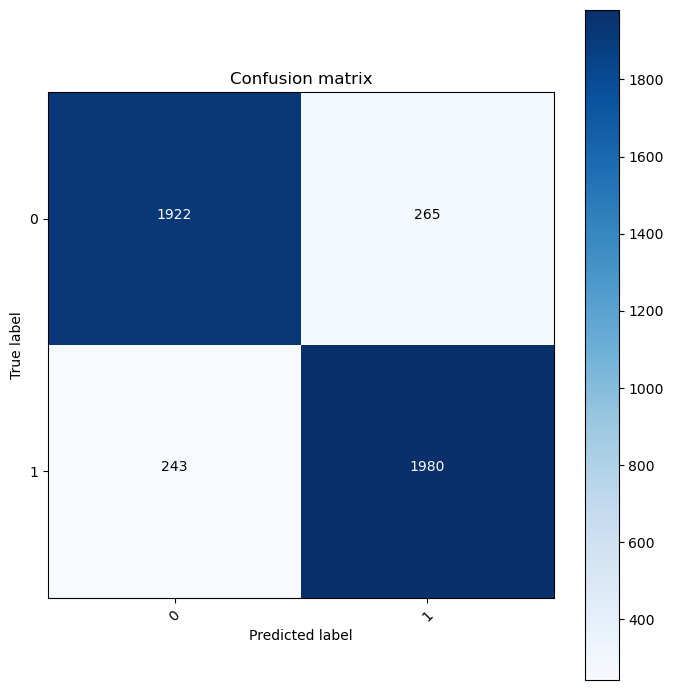

In [248]:
PlotTools.confusion_matrix(cm1, list(range(2)))


In [249]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train, pca_lbp_train], 
                  [pca_hist_val, pca_hog_val, pca_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((17636, 30), (4410, 30))

In [250]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.908843537414966
[[1987  200]
 [ 202 2021]]
Recall in 'XGB' = 0.9085505258344765
Precision in 'XGB' = 0.9077204202832344
F1 Score in 'XGB' = 0.9081352833638027


In [251]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((17636, 26), (4410, 26))

In [252]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.8868480725623583
[[1880  307]
 [ 192 2031]]
Recall in 'XGB' = 0.8596250571559213
Precision in 'XGB' = 0.9073359073359073
F1 Score in 'XGB' = 0.8828363465602254


In [254]:
features_train3 = None
features_val3 = None
evs = []
for ft, fv in zip([pca_kaze_train, pca_sift_train], 
                  [pca_kaze_val, pca_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train3 is None:
        features_train3 = ft
        features_val3 = fv
    else:
        features_train3 = combine_features([features_train3, ft])
        features_val3 = combine_features([features_val3, fv])
features_train3.shape, features_val3.shape

((17636, 15), (4410, 15))

In [255]:
model3 = train_model(features_train3, train_y, model_name='XGB', validation=(features_val3, val_y))
prob3 = model3.predict_proba(features_val3)

Validation Accuracy in 'XGB' = 0.76281179138322
[[1516  671]
 [ 375 1848]]
Recall in 'XGB' = 0.6931870141746685
Precision in 'XGB' = 0.8016922263352724
F1 Score in 'XGB' = 0.7435017165277097


In [261]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)
prob3 = model3.predict_proba(features_val3)
#prob4 = model4.predict_proba(features_val4)
#prob5 = model5.score(features_val, )
#prob6 = model6.predict_proba(features_val6)

In [262]:
prob = (prob1 + prob2 + prob3 + prob4 + prob6) / 5
y_hat = np.argmax(prob, axis=1)

In [263]:
metrics.accuracy_score(val_y, y_hat)


0.9133786848072563